# Assignment 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Student Grade Dataset

### K Means Clustering

In [2]:
#Loading student grade data
grade = pd.read_csv('student-mat.csv')
grade.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
#Deleting grade 1 and grade 2 as we will be predicting only for grade 3
grade = grade.drop(['G1','G2'], axis=1)

In [4]:
list(grade)

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G3']

In [5]:
grade['nursery'].unique()

array(['yes', 'no'], dtype=object)

In [45]:
#converting all categorical variables into dummy variables
cat_columns = ['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health']

X = pd.get_dummies(grade, columns = cat_columns)
X.head()

,age,failures,absences,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,0,6,6,1,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,17,0,4,6,1,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,15,3,10,10,1,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,15,0,2,15,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,16,0,4,10,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


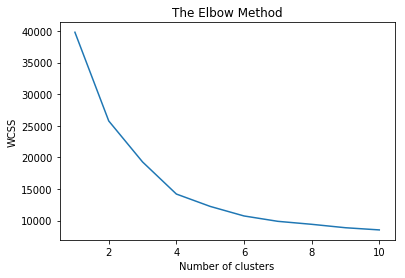

In [7]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### We observe that the optimum number of clusters are 4.

In [21]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X)

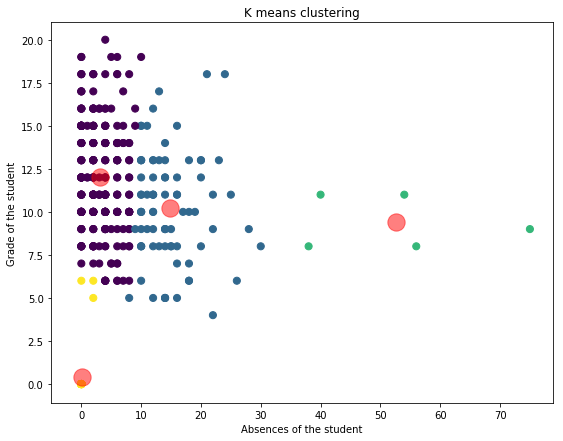

In [103]:
#plotting the k means
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X.iloc[:, 2], X['G3'], c=y_kmeans, s=50, cmap='viridis');
plt.title('K means clustering')
plt.xlabel('Absences of the student')
plt.ylabel('Grade of the student')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 3], c='red', s=300, alpha=0.5);

In [10]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [11]:
purity_score(X.G3, y_kmeans)

0.25063291139240507

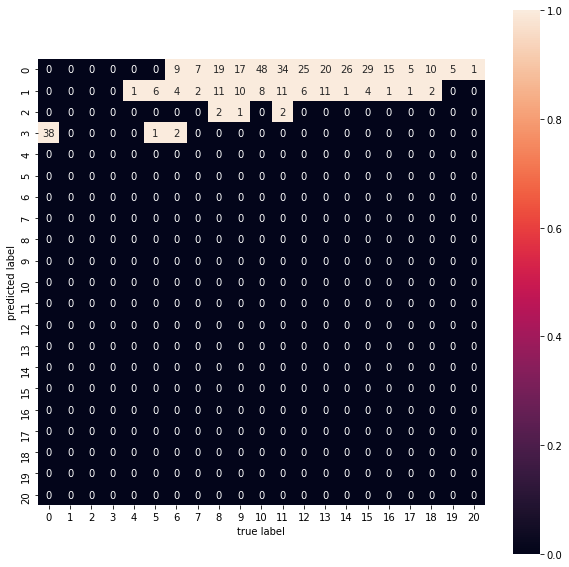

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(X.G3, y_kmeans)

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, vmin=0, vmax=1)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can observe that the purity score is 0.25 and also the confusion matrix shows that a very small amount of data is getting predicted and hence K means is not providing a good confidence in predicting the student grade.

### Expectation–Maximization Algorithm

In [115]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=42):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center i.e. the E-Step
        labels = pairwise_distances_argmin(X1, centers)

        # 2b. Find new centers from means of points i.e. the M-step
        new_centers = np.array([X1[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means EM Algo')

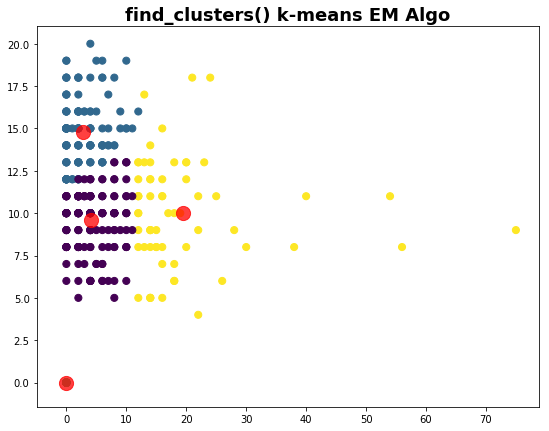

In [116]:
X1 = X.as_matrix()
centers, labels = find_clusters(X1, 4)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X1[:, 2], X1[:, 3], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75)
plt.title('find_clusters() k-means EM Algo', fontsize=18, fontweight='demi')

In [117]:
purity_score(X.G3, labels)

0.33164556962025316

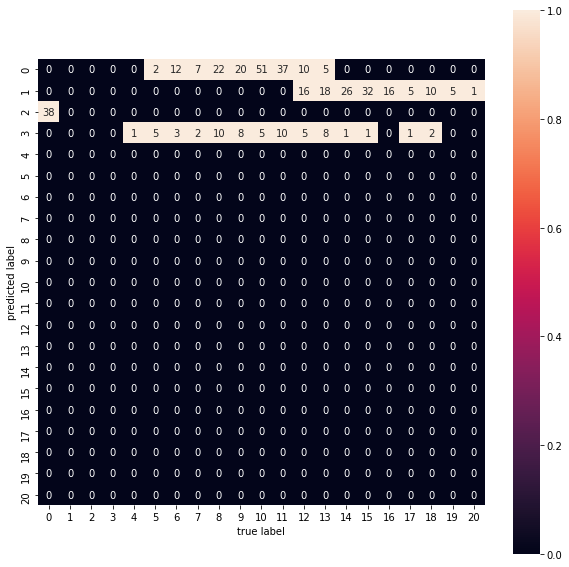

In [118]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(X.G3, labels)

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, vmin=0, vmax=1)
plt.xlabel('true label')
plt.ylabel('predicted label');

The K-Means alogrithm with Expectation and Maximization Algorithm we get a purity score of 0.33 and the confusion matrix also shows improvement.

### Feature Selection Algorithm

In [128]:
import statsmodels.api as sm

X2 = X.drop(['G3'], axis=1)
y2 = X.G3


def stepwise_selection(X2, y2, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X2.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y2, sm.add_constant(pd.DataFrame(X2[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y2, sm.add_constant(pd.DataFrame(X2[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X2, y2)

print('resulting features:')
print(result)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Add  failures                       with p-value 1.46566e-13
Add  freetime_3                     with p-value 0.00255907
resulting features:
['failures', 'freetime_3']


###### After using the backward elimination method for feature selection only 2 variables are shown to have significant contribution to the student grade and those are 'failures' and 'freetime'

###### Lets use Random Forresst algorithm to identify important features

In [192]:
X2 = X.drop(['G3'], axis=1)
y2 = X.G3

In [193]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

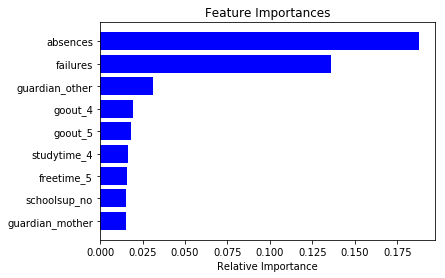

In [194]:
features = X2.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Here we observe that 2 variables are most important and i.e. 'Absences' and 'Failures', in determining the student grade.

### PCA

In [136]:
#converting all categorical variables into dummy variables and dropping the base columns
cat_columns = ['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health']

X = pd.get_dummies(grade, columns = cat_columns)
X.head()

,age,failures,absences,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,0,6,6,1,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,17,0,4,6,1,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,15,3,10,10,1,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,15,0,2,15,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,16,0,4,10,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [155]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (395, 95)
transformed shape: (395, 3)


In [157]:
print(pca.explained_variance_)

[64.19681472 21.18089968  1.75009387]


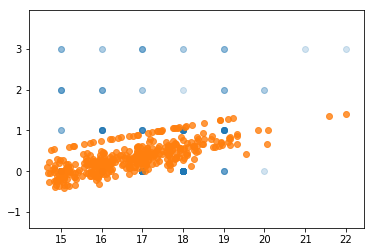

In [156]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

We can see from this plot that only the data with minimum variance is plotted. Also a lot of variance is explained in the first two PCA components.

### ICA

In [153]:
# Applying ICA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3)
ica.fit(X)
X_ica = ica.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_ica.shape)

original shape:    (395, 95)
transformed shape: (395, 3)


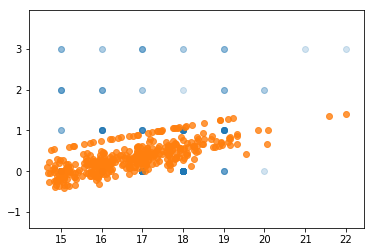

In [154]:
X_new = ica.inverse_transform(X_ica)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

We can observe reduced variance after using ICA, as well. Both PCA and ICA plots are very similar.

### Random projections

In [188]:
from sklearn import random_projection
rand_project = random_projection.GaussianRandomProjection(n_components=3)
rand_project.fit(X)
X_new = rand_project.transform(X)
X_new.shape

(395, 3)

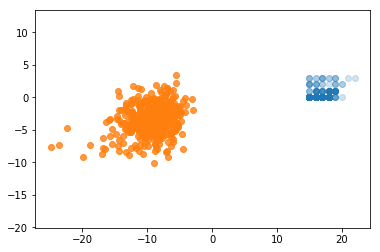

In [189]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

From the above figure we can observe that Random Projections we are not getting any good dimension reduction.

### Running the K-means clustering algorithm after PCA.

We are using PCA as it is giving us the a more accurate dimension reduction.

In [195]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (395, 95)
transformed shape: (395, 3)


In [199]:
#Applying K-Means
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X_pca)

In [200]:
X_pca.shape

(395, 3)

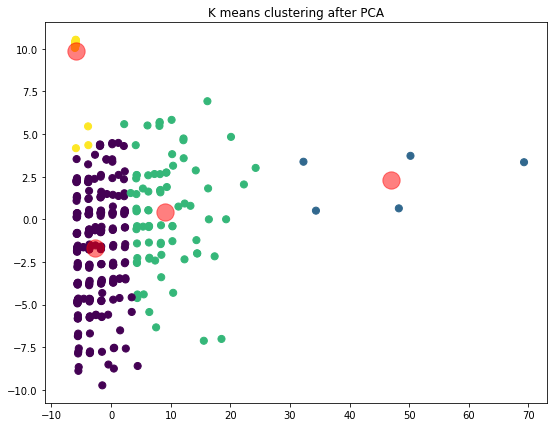

In [201]:
#plotting the k means
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis');
plt.title('K means clustering after PCA')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.5);

In [203]:
# Create a temp dataframe from our PCA projection data "x_pca"
df = pd.DataFrame(X_pca)
df['X_cluster'] = y_kmeans

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


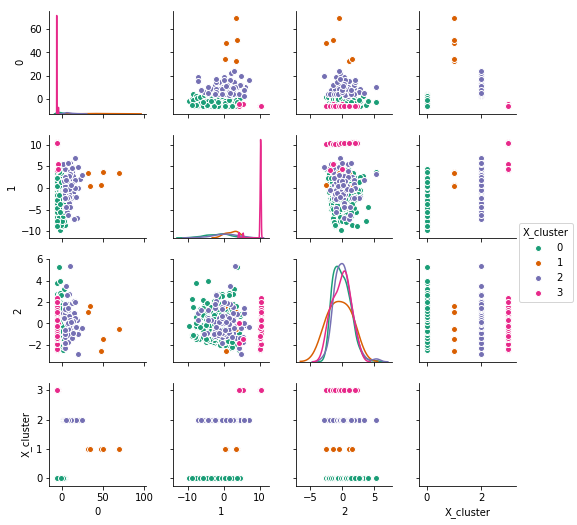

In [204]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

###### We can observe from the plots that the K-means are clusters according to the Absences column, which we had observed earlier in the normal K-means cluster plot which we had plotted for student grade against Absences. We can also observe the clusters are separately identifiable and appears to be flipped.

### Using the EM algorithm with PCA

In [210]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=0):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center i.e. the E-Step
        labels = pairwise_distances_argmin(X_pca, centers)

        # 2b. Find new centers from means of points i.e. the M-step
        new_centers = np.array([X_pca[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means EM Algo')

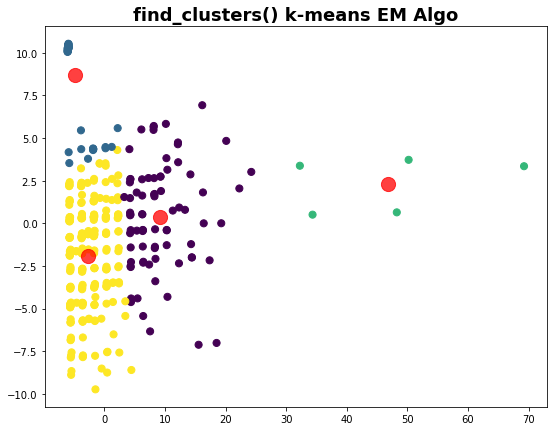

In [211]:
centers, labels = find_clusters(X_pca, 4)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('find_clusters() k-means EM Algo', fontsize=18, fontweight='demi')

###### We can observe from the plots that the K-means with EM algorithm are clusters according to the Absences column, which we had observed earlier in the normal K-means cluster plot which we had plotted for student grade against Absences. Also it is similar to the K-means with PCA plot.

## Breast Cancer Dataset

### K means clustering

In [225]:
#Load dataset
cancer = pd.read_csv('breast_cancer.csv')
cancer.head()

,ID,diagnosis,rad,tex,peri,area,sm,com,con,con_pt,...,rad_w,tex_w,peri_w,area_w,sm_w,com_w,con_w,con_pt_w,symm_w,frac_dim_w
0,842302.0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517.0,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903.0,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301.0,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402.0,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [217]:
list(cancer)

['diagnosis',
 'rad',
 'tex',
 'peri',
 'area',
 'sm',
 'com',
 'con',
 'con_pt',
 'symm',
 'frac_dim ',
 'rad_se',
 'tex_se',
 'peri_se',
 'area_se',
 'sm_se',
 'com_se',
 'con_se',
 'con_pt_se',
 'symm_se',
 'frac_dim_se ',
 'rad_w',
 'tex_w',
 'peri_w',
 'area_w',
 'sm_w',
 'com_w',
 'con_w',
 'con_pt_w',
 'symm_w',
 'frac_dim_w ']

In [250]:
X = pd.get_dummies(cancer, columns = ['diagnosis'], drop_first=True)
X = X.drop('ID', axis=1)
X.head()

,rad,tex,peri,area,sm,com,con,con_pt,symm,frac_dim,...,tex_w,peri_w,area_w,sm_w,com_w,con_w,con_pt_w,symm_w,frac_dim_w,diagnosis_M
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [242]:
X.shape

(571, 31)

In [251]:
X = X.dropna(axis=0)
X.shape

(569, 31)

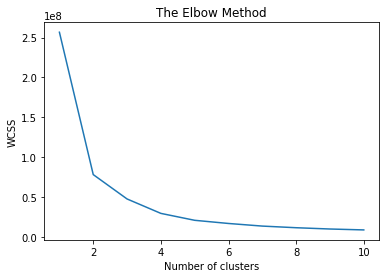

In [252]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### We observe that the number of clusters is 3.

In [253]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X)

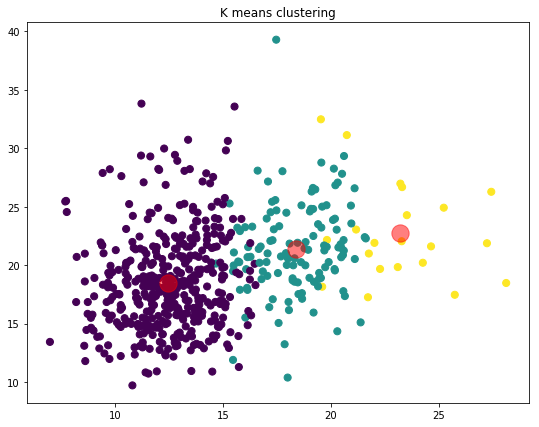

In [257]:
#plotting the k means
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis');
plt.title('K means clustering')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.5);

In [258]:
purity_score(X.diagnosis_M, y_kmeans)

0.8734622144112478

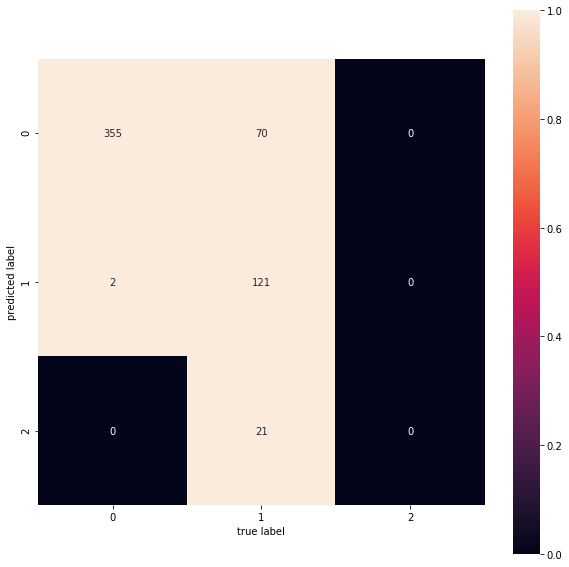

In [260]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(X.diagnosis_M, y_kmeans)

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, vmin=0, vmax=1)
plt.xlabel('true label')
plt.ylabel('predicted label');

From the purity score 0.87 and the confusion matrix we can see that the K-means algorithm is good predictor for this dataset.

### EM Algo with K Means

In [261]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=42):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center i.e. the E-Step
        labels = pairwise_distances_argmin(X1, centers)

        # 2b. Find new centers from means of points i.e. the M-step
        new_centers = np.array([X1[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means EM Algo')

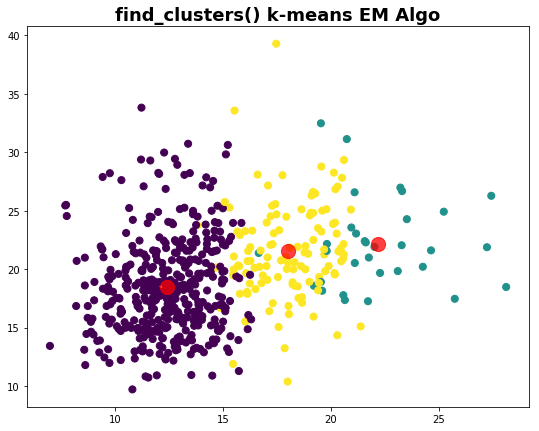

In [262]:
X1 = X.as_matrix()
centers, labels = find_clusters(X1, 3)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X1[:, 0], X1[:, 1], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('find_clusters() k-means EM Algo', fontsize=18, fontweight='demi')

In [263]:
purity_score(X.diagnosis_M, labels)

0.8840070298769771

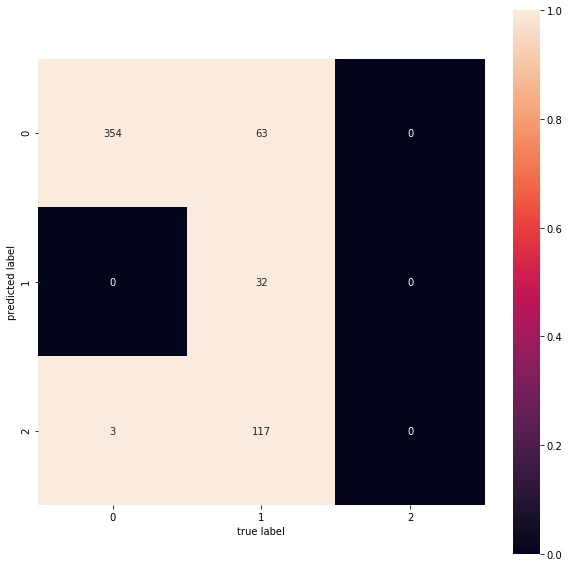

In [264]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(X.diagnosis_M, labels)

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=True, vmin=0, vmax=1)
plt.xlabel('true label')
plt.ylabel('predicted label');

EM Algorithm with K means gives a slightly better purity score of 0.88 and the confusion matrix shows that more number of labels match with the predicted labels.

### Feature Selection Algorithm - Random Forest method

In [265]:
X2 = X.drop(['diagnosis_M'], axis=1)
y2 = X.diagnosis_M

In [266]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

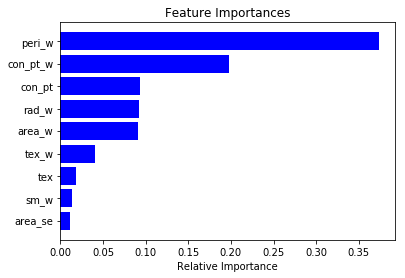

In [267]:
features = X2.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Here we see that 5 variables are most significant  and contribute more information to make a decision whether the tumor is malignant or benign.

### PCA

In [285]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (569, 31)
transformed shape: (569, 3)


In [286]:
pca.explained_variance_

array([443782.73097976,   7310.10041612,    703.8359105 ])

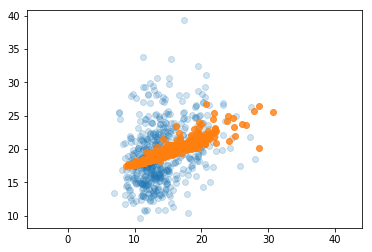

In [287]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

We can observe that PCA with 3 components cover most of the variance in the dataset.

### ICA

In [289]:
# Applying ICA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=3)
ica.fit(X)
X_ica = ica.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_ica.shape)

original shape:    (569, 31)
transformed shape: (569, 3)


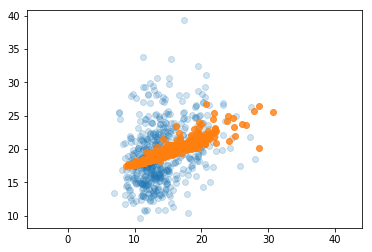

In [290]:
X_new = ica.inverse_transform(X_ica)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The ICA also produces the same result.

### Running the K-means clustering algorithm after PCA.

In [291]:
#Applying K-Means after PCA
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X_pca)

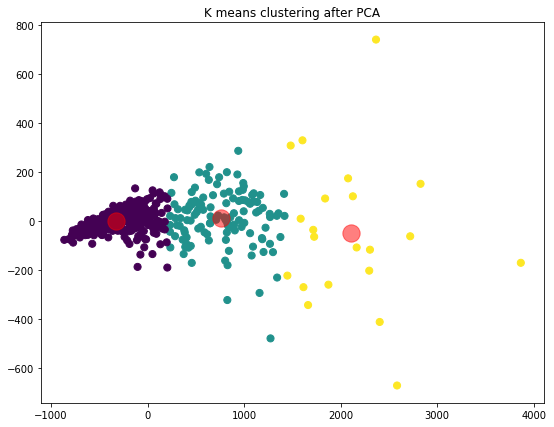

In [292]:
#plotting the k means
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis');
plt.title('K means clustering after PCA')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.5);

In [293]:
# Create a temp dataframe from our PCA projection data "x_pca"
df = pd.DataFrame(X_pca)
df['X_cluster'] = y_kmeans

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


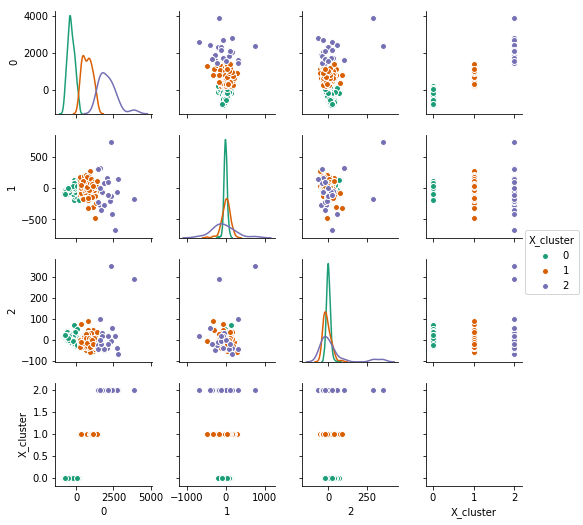

In [294]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

###### Here we observe that the K Means plot is different than the one plotted above. It is here because the only relevant variables was gained using PCA and this information was clustered by K means to give us a good prediction model.

### Using EM Algorithm with PCA

In [295]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=0):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center i.e. the E-Step
        labels = pairwise_distances_argmin(X_pca, centers)

        # 2b. Find new centers from means of points i.e. the M-step
        new_centers = np.array([X_pca[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

Text(0.5,1,'find_clusters() k-means EM Algo')

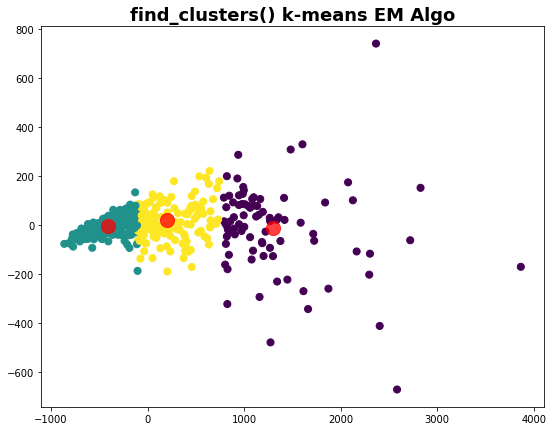

In [297]:
centers, labels = find_clusters(X_pca, 3)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('find_clusters() k-means EM Algo', fontsize=18, fontweight='demi')

###### Here also we observe that we get similar type of clusters and centers.